In [241]:
try:
    import mesa

except ImportError:
    !pip install mesa
    import mesa

import numpy as np
import matplotlib.pyplot as plt
import math
import networkx as nx

%matplotlib inline




# Helper Function

In [242]:
def get_distance(pos1, pos2):
    """
    calculate the distance between two positions of Euclidean distance
    :param pos1:
    :param pos2:
    :return: int
    """

    x1, y1 = pos1
    x2, y2 = pos2

    distance = math.sqrt((x1-x2)**2 + (y1-y2)**2)
    return distance

# Helper functions for DataCollector
def flatten(list_of_lists):
    """
    Flattens a list of lists into a single list.
    """
    return [item for sublist in list_of_lists for item in sublist]

def geometric_mean(list_of_price):
    """
    Calculates the geometric mean of a list of numbers.
    """

    #if not numbers:
    #    return 0.0 # 또는 None, 또는 에러 처리
    #product = 1
    #for x in numbers:
    #    product *= x
    #return product**(1/len(numbers))
    return np.exp(np.log(list_of_price).mean())

def get_trader(agent):
    if isinstance(agent, Trader):
        return agent.trade_partners
    else: return None

# Resource Classes

In [243]:
class Sugar(mesa.Agent):

    def __init__(self, model, pos, max_sugar):
        super().__init__(model)
        #self.grid.place_agent(sugar, pos)
        #self.pos=pos
        self.amount = max_sugar
        self.max_sugar = max_sugar

    def step(self):

        self.amount = min(self.amount + 1, self.max_sugar)
        # print("unique id :", self.unique_id, "amount: ", self.amount, "max :", self.max_sugar)



In [244]:
class Spice(mesa.Agent):

    def __init__(self, model, pos, max_spice):
        super().__init__(model)
        self.amount = max_spice
        self.max_spice = max_spice


    def step(self):

        self.amount = min(self.amount + 1, self.max_spice)
        # print("unique id :", self.unique_id, "amount: ", self.amount, "max :", self.max_spice)


In [245]:
class Trader(mesa.Agent):
    def __init__(self, model, pos, moore=False, sugar=0, spice=0, metabolism_sugar=0, metabolism_spice=0, vision=0):

        super().__init__(model)
        self.moore = moore
        self.sugar = sugar
        self.spice = spice
        self.metabolism_sugar = metabolism_sugar
        self.metabolism_spice = metabolism_spice
        self.vision = vision
        self.prices = []
        self.trade_partners = []



    def get_trader(self, pos):
        this_cell = self.model.grid.get_cell_list_contents(pos)

        for i in this_cell:
            if isinstance(i, Trader):
                return i
        return None

        #if isinstance(this_cell, Trader):
        #   return this_cell


    def get_spice(self, pos):

        agent = self.model.grid.get_cell_list_contents(pos)
        for a in agent:
            if type(a) is Spice:
                return a
        return None


    def get_spice_amount(self, pos):
        spice_patch = self.get_spice(pos)

        if spice_patch:
            return spice_patch.amount
        return 0


    def get_sugar(self, pos):
        """
        helper function to confirm whether sugar object is at pos
        return Sugar agent if sugar is in the pos
        else return None

        used to self.get_sugar_amount()
        used to self.eat()

        :param pos:
        :return: Sugar agent or None
        """

        agent = self.model.grid.get_cell_list_contents(pos)

        for a in agent:
            if type(a) is Sugar:
                return a
        return None


    def get_sugar_amount(self, pos):
        sugar_patch = self.get_sugar(pos)

        if sugar_patch:
            return sugar_patch.amount
        return 0


    def is_occupied_by_other(self, pos):
        """
        helper function to check if the position is occupied by other traders for self.move()
        :return bool
        """
        if pos == self.pos:
            return False
        this_cell = self.model.grid.get_cell_list_contents(pos)

        for a in this_cell:
            if isinstance(a, Trader):
                return True
        else:
            return False

    def cal_welfare(self, sugar, spice):
        """
        welfare function from Epstein and Axtell (1996)
        :param sugar:
        :param spice:
        :return: welfare value
        """
        total_metabolism = self.metabolism_sugar+self.metabolism_spice

        # Cobb-Douglas Production FUNCTION
        utilities = sugar**(self.metabolism_sugar/total_metabolism) * spice**(self.metabolism_spice/total_metabolism)
        return utilities

    def move(self):
        """
        - identify : all possible moves
        - evaluate : find best option
        - choose : to what is the best
        - move : to the best
        :return:
        """
        # 1, idenfiy all possible moves
        neighbors = [i for i in self.model.grid.get_neighborhood(self.pos, self.moore, include_center=True, radius=self.vision)
                     if not self.is_occupied_by_other(i)]

        welfares = [self.cal_welfare(self.sugar+self.get_sugar_amount(pos), self.spice+self.get_spice_amount(pos)) for pos in neighbors]

        max_welfare = max(welfares)

        candidate_indice = [i for i in range(len(welfares))
                           if math.isclose(welfares[i], max_welfare)]

        candidate = [neighbors[i] for i in candidate_indice]



        min_distance = min([get_distance(self.pos, pos) for pos in candidate])

        final_distance = [ pos for pos in candidate
                          if math.isclose(get_distance(self.pos, pos), min_distance, rel_tol=1e-02)]

        self.random.shuffle(final_distance)

        # move agent
        self.model.grid.move_agent(self, final_distance[0])

    def get_eat(self):

        # eat sugar
        sugar_patch = self.get_sugar(self.pos)

        if sugar_patch:
            self.sugar += sugar_patch.amount
            sugar_patch.amount = 0
        self.sugar -= self.metabolism_sugar

        #eat spice
        spice_patch = self.get_spice(self.pos)

        if spice_patch:
            self.spice += spice_patch.amount
            spice_patch.amount = 0
        self.spice -= self.metabolism_spice

    def is_starved(self):
        if self.sugar <= 0 or self.spice <= 0:
            return True
        return False

    def calculate_MRS(self):
        return (self.metabolism_sugar/self.metabolism_spice)*(self.spice/self.sugar)

    def calculate_sell_spice_amount(self, price):
        if price >= 1:
            sugar = 1
            spice = int(price)
        else:
            sugar = int(1/price)
            spice = 1
        return sugar, spice

    def sell_spice(self, other, sugar_exchanged, spice_exchanged):
        """
        exchange sugar and spice
        :param other:
        :param sugar_exchanged:
        :param spice_exchanged:
        :return:
        """
        self.sugar += sugar_exchanged
        self.spice -= spice_exchanged
        other.sugar -= sugar_exchanged
        other.spice += spice_exchanged



    def maybe_sell_spice(self, other, price, welfare_self, welfare_other):
        sugar_exchanged, spice_exchanged = self.calculate_sell_spice_amount(price)

        self_sugar = self.sugar + sugar_exchanged
        other_sugar = other.sugar - sugar_exchanged
        self_spice = self.spice - spice_exchanged
        other_spice = other.spice + spice_exchanged

        # check whether the agent have enough resources
        if (self_sugar) <= 0 or            (other_sugar <= 0) or            (self_spice <= 0) or            (other_spice <= 0):
            return False

        # Trade criteria #1
        both_agent_better_off = (welfare_self < self.cal_welfare(self_sugar, self_spice) and (welfare_other < other.cal_welfare(other_sugar, other_spice)))

        # Trade Criteria #2
        mrs_not_crossing = self.calculate_MRS() > other.calculate_MRS()

        if not (both_agent_better_off and mrs_not_crossing):
            return False

        # Criteria met, excute the trade
        self.sell_spice(other, sugar_exchanged, spice_exchanged)

        return True




    def trade(self, other):
        """
        helper function to trade with other traders
        used in trade_with_neighbors()
        :param other: trader agent object
        :return:
        """

        # confirm that sugar and spice are over 0
        assert self.sugar > 0
        assert self.spice > 0
        assert other.sugar > 0
        assert other.spice > 0

        # calculate marginal rate of substitution(MRS)
        mrs_self = self.calculate_MRS()
        mrs_other = other.calculate_MRS()

        # calculate each agents welfare
        welfare_self = self.cal_welfare(self.sugar, self.spice)
        welfare_other = other.cal_welfare(other.sugar, other.spice)


        if math.isclose(mrs_self, mrs_other):
            return

        # calculate price
        price = math.sqrt(mrs_self*mrs_other)

        if mrs_self > mrs_other:
            sold = self.maybe_sell_spice(other, price, welfare_self, welfare_other)
            if not sold:
                return
        else:
            sold = other.maybe_sell_spice(self, price, welfare_other, welfare_self)
            if not sold:
                return


        # capture data
        self.prices.append(price)
        self.trade_partners.append(other.unique_id)

        #continue trading
        #self.trade(other)


    def maybe_die(self):
        if self.is_starved():
            self.model.grid.remove_agent(self)
            self.model.agents.remove(self)

    def trade_with_neighbors(self):
        """
        trade with neighbors
        step 1. select neighbors who can trade with
        step 2. trade
        step 3. collect data
        :return:
        """


        neighors_agent = [self.get_trader(pos) for pos in self.model.grid.get_neighborhood(self.pos, self.moore, False, self.vision) if self.is_occupied_by_other(pos)]

        if len(neighors_agent) == 0:
            return

        for a in neighors_agent:
            if a:
                self.trade(a)

        return









# model class

In [246]:
class SugarscapeG1mt(mesa.Model):
    def __init__(self, width=50, height=50, initial_population=200,
                 endowment_min=20, endowment_max=50,
                 metabolism_min=1, metabolism_max=5,
                 vision_min=1, vision_max=5):
        
        # 부모 클래스(mesa.Model) 초기화
        super().__init__()
        #self.agents = mesa.AgentSet(self)

        self.width = width
        self.height = height

        # Initialize
        self.initial_population = initial_population
        self.endowment_min = endowment_min
        self.endowment_max = endowment_max
        self.metabolism_min = metabolism_min
        self.metabolism_max = metabolism_max
        self.vision_min = vision_min
        self.vision_max = vision_max

        # .Grid property
        # torus=True로 하면 팩맨처럼 맵이 연결됩니다.
        self.grid = mesa.space.MultiGrid(self.width, self.height, torus=True)
        # initiate data collector
        self.datacollector = mesa.DataCollector(
            model_reporters={"Trader": lambda m: m.agents.select(agent_type=Trader),
                             "Trader Volume": lambda m: sum(len(a.trade_partners) for a in m.agents.select(agent_type=Trader)),
                             "Price": lambda m: geometric_mean(flatten([a.prices for a in m.agents.select(agent_type=Trader) if a.prices]))},
            agent_reporters={"Trader Network": lambda a: get_trader(a)}
        )


        self.sugar_distribution = np.genfromtxt("sugar-map.txt")
        self.spice_distribution = np.flip(self.sugar_distribution, axis=0)

        # 헬퍼 함수 make_map 호출
        # self.make_map()


        for _, (x, y) in self.grid.coord_iter():
            max_sugar = self.sugar_distribution[x, y]
            if max_sugar > 0:
                sugar = Sugar(self, (x,y), max_sugar)
                self.grid.place_agent(sugar, (x, y))
                #self.agents.add(sugar) # AgentSet에 추가

            max_spice = self.spice_distribution[x, y]
            if max_spice > 0:
                spice = Spice(self, (x,y), max_spice)
                self.grid.place_agent(spice, (x, y))
                #self.agents.add(spice) # AgentSet에 추가
        for i in range(self.initial_population):
            x = self.random.randrange(self.width)
            y = self.random.randrange(self.height)

            sugar = self.random.randrange(self.endowment_min, self.endowment_max + 1)
            spice = self.random.randrange(self.endowment_min, self.endowment_max + 1)

            metabolism_sugar = self.random.randrange(self.metabolism_min, self.metabolism_max + 1)
            metabolism_spice = self.random.randrange(self.metabolism_min, self.metabolism_max + 1)

            vision = self.random.randrange(self.vision_min, self.vision_max + 1)

            # Initiate individual agent
            trader = Trader(self, (x,y), moore=False, # moore는 키워드 인자로 유지
                        sugar=sugar, spice=spice, # 나머지 인자들도 키워드 인자로 명시
                        metabolism_sugar=metabolism_sugar, metabolism_spice=metabolism_spice,
                        vision=vision)
            # Place agent
            self.grid.place_agent(trader, (x,y))
            # self.schedule.add(trader) # Mesa 3.0+에서는 필요 없으므로 삭제
            # print(trader.unique_id, trader.pos, trader.sugar, trader.spice, trader.metabolism_sugar,trader.metabolism_spice, trader.vision)

    def make_map(self):

        # 도화지를 가로로 길게(12x6 크기) 준비합니다.
        plt.figure(figsize=(12, 6))

        # 첫 번째 그림: 설탕 지도 (1행 2열 중 1번째)
        plt.subplot(1, 2, 1)
        plt.imshow(self.sugar_distribution, origin="lower", cmap="Oranges")
        plt.title("Sugar Map")
        plt.colorbar()

        # 두 번째 그림: 향신료 지도 (1행 2열 중 2번째)
        plt.subplot(1, 2, 2)
        plt.imshow(self.spice_distribution, origin="lower", cmap="BuPu")
        plt.title("Spice Map")
        plt.colorbar()


    def get_shuffled_traders(self): # 메서드 이름을 더 명확하게 변경
        traders = list(self.agents.select(agent_type=Trader)) # Trader 에이전트 리스트를 가져옴
        self.random.shuffle(traders) # 리스트를 제자리에서 섞음
        return traders # 섞인 리스트를 반환


    def step(self):

        self.agents.do("step")


        trader_shuffle = self.get_shuffled_traders()

        for agent in trader_shuffle:
            agent.prices=[]
            agent.trade_partners=[]
            agent.move()
            agent.get_eat()
            agent.maybe_die()

        trader_shuffle = self.get_shuffled_traders()

        for agent in trader_shuffle:
            agent.trade_with_neighbors()

        # collect model level data
        self.datacollector.collect(self)

    def run_model(self,step_count=500):
        for i in range(step_count):
            self.step()


# Run Model


In [247]:
model = SugarscapeG1mt()
model.run_model(step_count=100)

# Analyze Data

In [252]:
result = model.datacollector.get_model_vars_dataframe()
result

,Trader,Trader Volume,Price
0,(),266,0.995319
1,(),237,1.041954
2,(),170,0.970929
3,(),139,1.074625
4,(),129,1.080112
...,...,...,...
95,(),13,1.032094
96,(),13,0.958292
97,(),14,0.982865
98,(),10,0.812456


<Axes: >

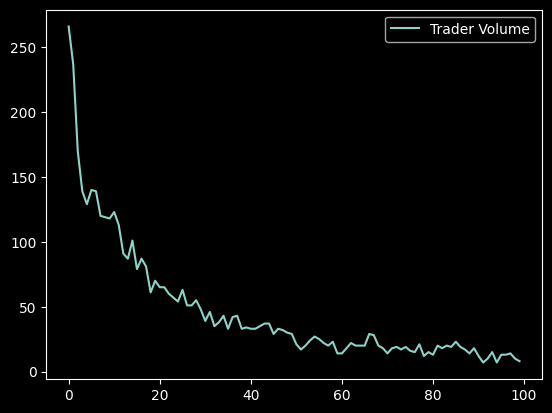

In [253]:
result.plot(y="Trader Volume", use_index=True)


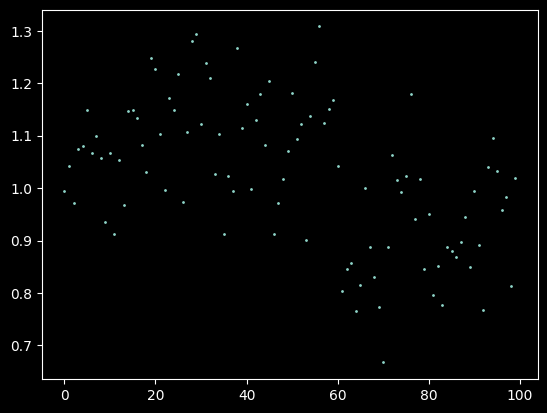

In [254]:
y=list(result["Price"])
x=range(len(y))

plt.scatter(x,y, s=1)

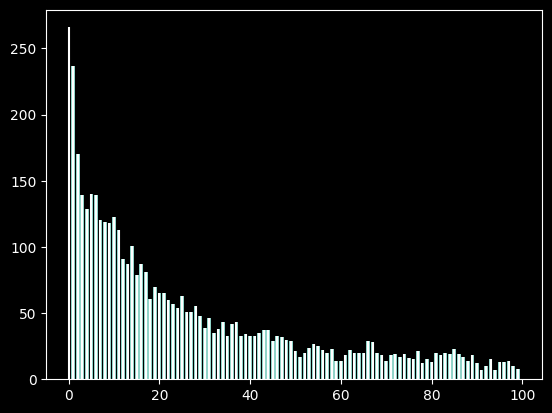

In [255]:
plt.bar(result.index[1:], result["Trader Volume"][1:])

for i in range(len(y)):
    plt.vlines(i,0,result["Trader Volume"][i])

In [257]:
agent_result = model.datacollector.get_agent_vars_dataframe()
agent_result_2 = agent_result[agent_result["Trader Network"].notnull()]

In [258]:
agent_result_2

Trader Network
Step  AgentID                                
1.0   4139                                 []
      4140     [4178, 4294, 4259, 4147, 4287]
      4141                             [4238]
      4142                 [4158, 4169, 4336]
      4143                             [4266]
...                                       ...
100.0 4331                             [4189]
      4333                                 []
      4334                                 []
      4337                                 []
      4338                                 []

[10714 rows x 1 columns]

In [263]:
G=nx.Graph()

# Add all Trader agents' unique_ids as nodes to the graph.
# model.agents.select(agent_type=Trader) returns a list of Trader agent objects.
# We extract their unique_ids to use as node identifiers.
trader_ids = [trader.unique_id for trader in model.agents.select(agent_type=Trader)]
G.add_nodes_from(trader_ids)

# Iterate through the agent_result_2 DataFrame to add edges.
# agent_result_2 has a MultiIndex (step, agent_id).
# The 'notnull()' filter applied to agent_result_2 ensures 'row["Trader Network"]' is not None.
for idx, row in agent_result_2.iterrows(): # Corrected typo: 'interrows' to 'iterrows'
    if len(row["Trader Network"]) > 0:
        source_agent_id = idx[1] # The agent_id from the MultiIndex
        for target_agent_id in row["Trader Network"]:
            # networkx's add_edge will automatically add nodes if they don't exist.
            # This means if a trader died, their ID might still appear as a node if they were a trade partner.
            G.add_edge(source_agent_id, target_agent_id)


print("Connectivity: ", nx.node_connectivity(G), "Clustering: ",
      nx.average_clustering(G), "Efficiency: ", nx.global_efficiency(G))

try:
    print("Diameter: ", nx.diameter(G))
except nx.NetworkXError: # More specific exception handling for disconnected graphs
    print("Some traders not connected, cannot calculate diameter for a disconnected graph.")
except Exception as e: # Catch any other unexpected errors
    print(f"An unexpected error occurred while calculating diameter: {e}")

Connectivity:  1 Clustering:  0.41960328754365617 Efficiency:  0.42275233309414656
Diameter:  7


(array([37., 37., 30., 32., 25., 22.,  9.,  6.,  1.,  1.]),
 array([ 1. ,  5.9, 10.8, 15.7, 20.6, 25.5, 30.4, 35.3, 40.2, 45.1, 50. ]),
 <BarContainer object of 10 artists>)

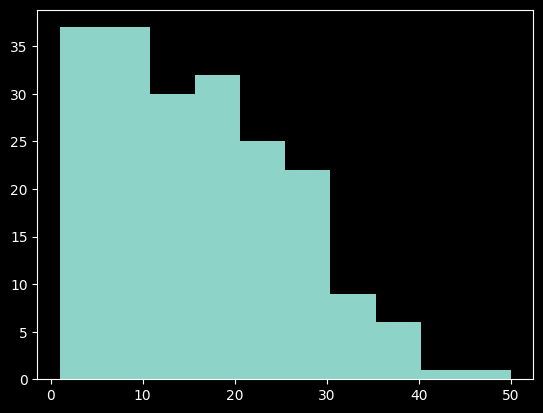

In [265]:
degree = [ i for n, i in G.degree()]
plt.hist(degree)

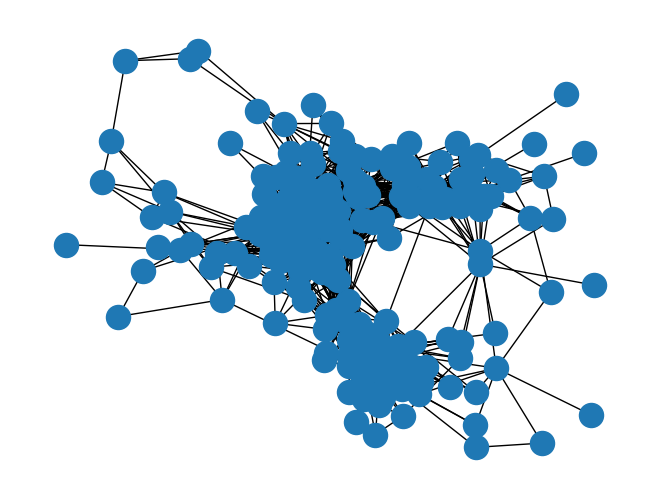

In [266]:
nx.draw(G)